<center>
    <h1 style="color: #3498db;">Aplicación de Redes Neuronales Recurrentes para la serie del Atleta Colombiano Iván</h1>
</center>

<h2 style="color: #e67e22; text-align: left;">Librerías Necesarias</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

#from keras import initializers
#from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import load_model
#from tensorflow.keras.regularizers import l1, l2
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
%matplotlib inline

In [3]:
import gc
gc.collect()

26

<h2 style="color: #e67e22; text-align: left;">Descripción de la serie</h2>

In [4]:
ruta = r"C:\Users\Lenovo\Desktop\shyni\Serie_Ivan.xlsx"

# Lee el archivo Excel
df = pd.read_excel(ruta,index_col=0)
# Muestra las primeras filas del DataFrame
print(df.head())
df.size

              KMS
DATE             
2018-12-31   17.3
2019-01-07   86.4
2019-01-14  107.3
2019-01-21  163.1
2019-01-28  153.5


268

In [5]:
df.index = pd.to_datetime(df.index, infer_datetime_format=True)

In [6]:
df

,KMS
DATE,
2018-12-31,17.3
2019-01-07,86.4
2019-01-14,107.3
2019-01-21,163.1
2019-01-28,153.5
...,...
2024-01-15,202.2
2024-01-22,200.9
2024-01-29,160.7


In [7]:
nof_missing_values = sum(np.isnan(df['KMS']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

0 observations are missing.
This is 0.000% of the total.


In [8]:
df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['KMS']))

print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


<h2 style="color: #e67e22; text-align: left;">RNN Regression</h2>

In [9]:
use_features = ['KMS'] # continuous input
target = ['KMS'] # continuous output
n_steps_ahead = 1 # forecasting horizon

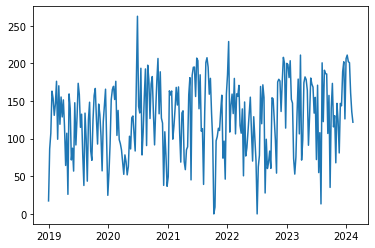

In [10]:
plt.plot(df['KMS'])

In [11]:
df.dropna(inplace=True)
print(df)

              KMS
DATE             
2018-12-31   17.3
2019-01-07   86.4
2019-01-14  107.3
2019-01-21  163.1
2019-01-28  153.5
...           ...
2024-01-15  202.2
2024-01-22  200.9
2024-01-29  160.7
2024-02-05  135.7
2024-02-12  121.8

[268 rows x 1 columns]


<h2 style="color: #e67e22; text-align: left;">Estacionariedad</h2> 

Es esencial determinar si la serie de tiempo es "estacionaria". Informalmente, la estacionariedad ocurre cuando la autocovarianza es independiente del tiempo. No establecer la estacionariedad casi con certeza conducirá a una mala interpretación de la identificación del modelo y las pruebas diagnósticas. Además, la estacionariedad es decisiva para caracterizar el problema de predicción y determinar si se debe usar una arquitectura más avanzada. En particular, podemos esperar que una RNN simple funcione mal si los datos no son estacionarios, ya que la RNN presenta una autocovarianza fija.

Realizamos una prueba de Dickey-Fuller Aumentada para establecer la estacionariedad bajo el supuesto de que la serie de tiempo tiene un sesgo constante pero no presenta una tendencia temporal. En otras palabras, asumimos que la serie de tiempo ya está des-trendida.

Si la prueba de estacionariedad falla, incluso después de des-trender la serie de tiempo, entonces un recurso potencial es simplemente tomar diferencias de la serie de tiempo y predecir $\Delta y_t$.


In [12]:
sample = df['KMS'][:268]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [13]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -8.294440147260046
p-value: 4.1767430606472077e-13,
N: 266, 
critical values: {'1%': -3.455175292841607, '5%': -2.8724677563219485, '10%': -2.57259315846006}


Aquí rechazamos la hipótesis nula ya que el valor p es menor que 0.01, por lo tanto,  podemos rechazar la prueba al nivel de confianza del 99%. Esto sugiere que la serie temporal  es **estacionaria**.


In [26]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=52)
print(pacf)

[ 1.          0.35982968  0.1112808  -0.05356433  0.04189731 -0.03024228
 -0.03798688 -0.00208805 -0.01438159  0.06928826  0.01587568 -0.11641937
 -0.04475874 -0.02741998  0.01813617  0.047017    0.0398394   0.02744579
 -0.04711411  0.01880179 -0.03288715  0.04010612 -0.04665097 -0.00705715
 -0.06939977 -0.08739706 -0.12940267 -0.04402874  0.12694111  0.03792325
  0.10913632 -0.05427822  0.02069914  0.04766867 -0.01439542  0.11169568
 -0.01045524  0.09871045 -0.12141682  0.07815533 -0.09998191 -0.07975051
  0.01579923  0.0805939   0.04519596  0.07646898  0.03325565 -0.09312151
  0.02436844  0.10388561  0.0086983   0.00908146  0.14322692]


In [27]:
T = len(df[use_features])
sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)
df[use_features].head()

,KMS
DATE,
2018-12-31,17.3
2019-01-07,86.4
2019-01-14,107.3
2019-01-21,163.1
2019-01-28,153.5


In [195]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        n_steps=n_steps
        print('n_steps set to', n_steps)
        break

n_steps set to 2


In [ ]:
 n_steps= n_steps+1

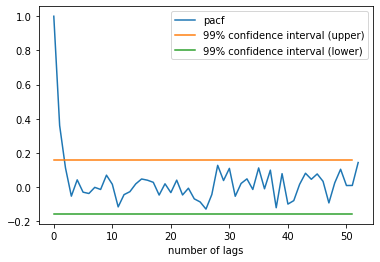

In [196]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*52, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*52, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

Por lo que para este caso el número de retardos significartivo es de **2**.

<h2 style="color: #e67e22; text-align: left;"> Dividiendo la serie temporal en conjuntos de entrenamiento y prueba</h2>

In [216]:
train_weight = 0.80
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

<h2 style="color: #e67e22; text-align: left;">Estandarización de los datos</h2> 

La estandarización de los datos es importante para evitar posibles dificultades de escala en el ajuste del modelo. Cuando hay más de una característica (covariable), la estandarización evita que una característica domine sobre otra debido a escalas dispares.
Para evitar introducir un sesgo de anticipación en la predicción, debemos reescalar los datos de entrenamiento sin conocimiento del conjunto de prueba. Por lo tanto, simplemente estandarizaremos el conjunto de entrenamiento utilizando la media y la desviación estándar del conjunto de entrenamiento y no de toda la serie temporal. Además, para evitar introducir un sesgo sistemático en el conjunto de prueba, utilizamos la misma normalización para el conjunto de prueba: la media y la desviación estándar del conjunto de entrenamiento se utilizan para normalizar el conjunto de prueba.

In [217]:
mu = float(df_train.mean())
sigma = float(df_train.std())
print(sigma)
print(mu)
stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)
print(df_train)
print(df_test)

48.97102603165779
124.08225233644858
                 KMS
DATE                
2018-12-31 -2.180519
2019-01-07 -0.769481
2019-01-14 -0.342698
2019-01-21  0.796752
2019-01-28  0.600717
...              ...
2023-01-02  1.550258
2023-01-09  1.517586
2023-01-16  1.164316
2023-01-23  1.621729
2023-01-30  0.574171

[214 rows x 1 columns]
                 KMS
DATE                
2023-02-06  0.472070
2023-02-13 -1.034944
2023-02-20 -1.453559
2023-02-27 -0.992061
2023-03-06  0.192313
2023-03-13  1.123475
2023-03-20 -0.363118
2023-03-27  1.774881
2023-04-03 -1.073742
2023-04-10 -0.532606
2023-04-17  1.025458
2023-04-24  1.182694
2023-05-01  1.111223
2023-05-08  0.823298
2023-05-15 -0.671463
2023-05-22  0.118800
2023-05-29  1.152064
2023-06-05  0.986660
2023-06-12  0.904979
2023-06-19  0.200481
2023-06-26  0.627264
2023-07-03 -1.059448
2023-07-10  0.958072
2023-07-17 -1.412718
2023-07-24 -0.330445
2023-07-31 -2.262200
2023-08-07  1.564553
2023-08-14 -0.030268
2023-08-21  1.364434
2023-08-28  1.2

<h2 style="color: #e67e22; text-align: left;">Formato datos para la RNNs</h2> 

TensorFlow utiliza tensores para representar los datos. Para realizar el aprendizaje de secuencias, la serie temporal de variables debe transformarse en una serie de subsecuencias superpuestas.

In [218]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [219]:
n_steps_ahead

1

Primero transformaremos los datos de entrada y salida del entrenamiento

In [220]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [221]:
print(y_train_timestamps)

DatetimeIndex(['2019-01-14', '2019-01-21', '2019-01-28', '2019-02-04',
               '2019-02-11', '2019-02-18', '2019-02-25', '2019-03-04',
               '2019-03-11', '2019-03-18',
               ...
               '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19',
               '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16',
               '2023-01-23', '2023-01-30'],
              dtype='datetime64[ns]', name='DATE', length=212, freq=None)


In [222]:
print(y_test_timestamps)

DatetimeIndex(['2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13',
               '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10',
               '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08',
               '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05',
               '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03',
               '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31',
               '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28',
               '2023-09-04', '2023-09-11', '2023-09-18', '2023-09-25',
               '2023-10-02', '2023-10-09', '2023-10-16', '2023-10-23',
               '2023-10-30', '2023-11-06', '2023-11-13', '2023-11-20',
               '2023-11-27', '2023-12-04', '2023-12-11', '2023-12-18',
               '2023-12-25', '2024-01-01', '2024-01-08', '2024-01-15',
               '2024-01-22', '2024-01-29', '2024-02-05', '2024-02-12'],
              dtype='datetime64[ns]', name='DATE', freq=None)


In [223]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(212, 2, 1), (212, 1), (52, 2, 1), (52, 1)]


<h2 style="color: #e67e22; text-align: left;">Especificación del modelo</h2> 

**Red Neuronal Recurrente**

In [224]:
def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


- **keras.layers.SimpleRNN:** Agrega una capa SimpleRNN al modelo.
- **n_units:** Número de unidades/neuronas en la capa SimpleRNN.
- **activation='tanh':** Función de activación tangente hiperbólica.
- **kernel_initializer, bias_initializer, recurrent_initializer:** Inicializadores de pesos y sesgos para los pesos y la parte recurrente de la capa.
- **kernel_regularizer:** Regularización L1 aplicada a los pesos de la capa.
- **input_shape:** Forma de entrada del modelo, basada en las dimensiones de los datos de entrenamiento x_train.
- **unroll=True:** Desenrolla la capa SimpleRNN para acelerar el entrenamiento si es posible.
- **stateful=False:** No mantiene estados persistentes entre muestras.
- **loss='mean_squared_error':** Función de pérdida de error cuadrático medio para problemas de regresión.
- **optimizer='adam':** Optimizador Adam, un algoritmo de optimización eficiente para el entrenamiento de redes neuronales.

**Red Neuronal GRU**

In [225]:
def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

- **keras.layers.GRU:** Agrega una capa GRU al modelo.
- **n_units:** Número de unidades/neuronas en la capa GRU.
- **activation='tanh':** Función de activación tangente hiperbólica.
- **kernel_initializer, bias_initializer, recurrent_initializer:** Inicializadores de pesos y sesgos para los pesos y la parte recurrente de la capa.
- **kernel_regularizer:** Regularización L1 aplicada a los pesos de la capa.
- **input_shape:** Forma de entrada del modelo, basada en las dimensiones de los datos de entrenamiento x_train.
- **unroll=True:** Desenrolla la capa GRU para acelerar el entrenamiento si es posible.
- **loss='mean_squared_error':** Función de pérdida de error cuadrático medio para problemas de regresión.
- **optimizer='adam':** Optimizador Adam, un algoritmo de optimización eficiente para el entrenamiento de redes neuronales.

**Red Neuronal LSTM**

In [226]:
def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

- **keras.layers.LSTM:** Agrega una capa LSTM al modelo.
- **n_units:** Número de unidades/neuronas en la capa LSTM.
- **activation='tanh':** Función de activación tangente hiperbólica.
- **kernel_initializer, bias_initializer, recurrent_initializer:** Inicializadores de pesos y sesgos para los pesos y la parte recurrente de la capa.
- **kernel_regularizer:** Regularización L1 aplicada a los pesos de la capa.
- **input_shape:** Forma de entrada del modelo, basada en las dimensiones de los datos de entrenamiento x_train.
- **unroll=True:** Desenrolla la capa LSTM para acelerar el entrenamiento si es posible.
- **1:** Una sola neurona en la capa densa para problemas de regresión.
- **kernel_initializer, bias_initializer:** Inicializadores de pesos y sesgos para la capa densa.
- **kernel_regularizer:** Regularización L1 aplicada a los pesos de la capa densa.
- **loss='mean_squared_error':** Función de pérdida de error cuadrático medio para problemas de regresión.
- **optimizer='adam':** Optimizador Adam, un algoritmo de optimización eficiente para el entrenamiento de redes neuronales.

Utilice un tamaño de lote de 1000 ya que el conjunto de datos es razonablemente grande y de lo contrario el tiempo de entrenamiento sería demasiado largo. Se han utilizado 20 épocas aquí, pero un enfoque mejor sería utilizar un criterio de parada a través de un callback.

In [227]:
max_epochs = 20 #Dejar mil
batch_size = 1000

In [228]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)

In [229]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [230]:
params

{'rnn': {'model': None,
  'function': <function __main__.SimpleRNN_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 20,
  'color': 'blue',
  'label': 'RNN'},
 'gru': {'model': None,
  'function': <function __main__.GRU_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'orange',
  'label': 'GRU'},
 'lstm': {'model': None,
  'function': <function __main__.LSTM_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'red',
  'label': 'LSTM'}}

<h2 style="color: #e67e22; text-align: left;">Cargando modelos preentrenados</h2>  

Entrenar los modelos lleva varias horas. Para ahorrar tiempo, puedes cargar los modelos ya ajustados en su lugar:

In [231]:
do_training = True # Set to True if you wish to train your own models

In [232]:
params.keys()

dict_keys(['rnn', 'gru', 'lstm'])

In [233]:
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Ivan-SAVED-' + key + '.hdf5')

<h2 style="color: #e67e22; text-align: left;">Validación cruzada</h2> 

La celda siguiente realiza una búsqueda en cuadrícula para optimizar n_units y l1_reg para cada uno de los modelos utilizando los datos de entrenamiento.

Los resultados se validan cruzadamente para evitar el sobreajuste. Se utiliza la función TimeSeriesSplit de Scikit-Learn para dividir los datos en 5 pares de conjuntos de entrenamiento y prueba, donde los datos de prueba siempre están adelante en el tiempo respecto a los datos de entrenamiento.

In [ ]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20,30]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9068\2699852436.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


Epoch 1/20
1/1 - 4s - loss: 1.2633 - 4s/epoch - 4s/step
Epoch 2/20
1/1 - 0s - loss: 1.2569 - 19ms/epoch - 19ms/step
Epoch 3/20
1/1 - 0s - loss: 1.2506 - 14ms/epoch - 14ms/step
Epoch 4/20
1/1 - 0s - loss: 1.2443 - 15ms/epoch - 15ms/step
Epoch 5/20
1/1 - 0s - loss: 1.2382 - 17ms/epoch - 17ms/step
Epoch 6/20
1/1 - 0s - loss: 1.2321 - 14ms/epoch - 14ms/step
Epoch 7/20
1/1 - 0s - loss: 1.2261 - 16ms/epoch - 16ms/step
Epoch 8/20
1/1 - 0s - loss: 1.2202 - 19ms/epoch - 19ms/step
Epoch 9/20
1/1 - 0s - loss: 1.2143 - 17ms/epoch - 17ms/step
Epoch 10/20
1/1 - 0s - loss: 1.2086 - 14ms/epoch - 14ms/step
Epoch 11/20
1/1 - 0s - loss: 1.2029 - 20ms/epoch - 20ms/step
Epoch 12/20
1/1 - 0s - loss: 1.1973 - 16ms/epoch - 16ms/step
Epoch 13/20
1/1 - 0s - loss: 1.1918 - 24ms/epoch - 24ms/step
Epoch 14/20
1/1 - 0s - loss: 1.1863 - 19ms/epoch - 19ms/step
Epoch 15/20
1/1 - 0s - loss: 1.1810 - 16ms/epoch - 16ms/step
Epoch 16/20
1/1 - 0s - loss: 1.1757 - 17ms/epoch - 17ms/step
Epoch 17/20
1/1 - 0s - loss: 1.1705 -

#### Train cross-validated model

Si se realizó la búsqueda en cuadrícula, los parámetros n_units y l1_reg con el mejor rendimiento promedio a través de las divisiones de validación cruzada se utilizan para entrenar los modelos en el conjunto de entrenamiento completo. Si no se realizó, se utilizan los valores de la inicialización de params mencionados anteriormente.

In [ ]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

In [173]:
for key in params.keys():
    params[key]['model'].save('RNNs-Ivan-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

<h2 style="color: #e67e22; text-align: left;">Predicción</h2> 

Ahora aplicaremos los modelos RNN ajustados al conjunto de entrenamiento y al conjunto de prueba por separado. Luego podemos evaluar informalmente el grado de sobreajuste

In [174]:
y_train= (y_train*sigma)+mu
y_test=(y_test*sigma)+mu

In [175]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['pred_train']=(params[key]['pred_train']*sigma)+mu
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['pred_test']=(params[key]['pred_test']*sigma)+mu
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_489"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_163 (SimpleRNN)  (None, 5)                 35        
                                                                 
 dense_489 (Dense)           (None, 1)                 6         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 57ms/step
Model: "sequential_490"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_163 (GRU)               (None, 20)                1380      
                                                                 
 dense_490 (Dense)           (None, 1)                 21        
                                              

<h2 style="color: #e67e22; text-align: left;"> Rendimiento del modelo</h2>

Finalmente evaluar el rendimiento del modelo dentro y fuera de muestra usando el MSE. Esperamos que el error medio sea mayor en el conjunto de prueba que en el conjunto de entrenamiento.

<h2 style="color: #e67e22; text-align: left;">Devolviendo los valores a la escala original</h2> 

In [179]:
print(sigma)
print(mu)
stdize_output = lambda x: (x *sigma) +mu
df_train = df_train.apply(stdize_output)
df_test = df_test.apply(stdize_output)

49.020962991398775
123.89467555555554


In [180]:
d_train = df[use_features].iloc[:split]
d_test = df[use_features].iloc[split:]
print(d_train)
print(d_test)

              KMS
DATE             
2018-12-31   17.3
2019-01-07   86.4
2019-01-14  107.3
2019-01-21  163.1
2019-01-28  153.5
...           ...
2023-03-20  106.3
2023-03-27  211.0
2023-04-03   71.5
2023-04-10   98.0
2023-04-17  174.3

[225 rows x 1 columns]
              KMS
DATE             
2023-04-24  182.0
2023-05-01  178.5
2023-05-08  164.4
2023-05-15   91.2
2023-05-22  129.9
2023-05-29  180.5
2023-06-05  172.4
2023-06-12  168.4
2023-06-19  133.9
2023-06-26  154.8
2023-07-03   72.2
2023-07-10  171.0
2023-07-17   54.9
2023-07-24  107.9
2023-07-31   13.3
2023-08-07  200.7
2023-08-14  122.6
2023-08-21  190.9
2023-08-28  186.3
2023-09-04  185.9
2023-09-11  106.9
2023-09-18  157.4
2023-09-25   35.2
2023-10-02  140.6
2023-10-09  173.4
2023-10-16  115.6
2023-10-23  130.5
2023-10-30   67.9
2023-11-06  146.9
2023-11-13  123.5
2023-11-20   81.0
2023-11-27  146.8
2023-12-04  143.6
2023-12-11  188.8
2023-12-18  202.1
2023-12-25  126.2
2024-01-01  206.3
2024-01-08  211.0
2024-01-15  202.2
2024

In [181]:
print(params.keys())

dict_keys(['rnn', 'gru', 'lstm'])


In [182]:
y_vals=(y_vals*sigma)+mu

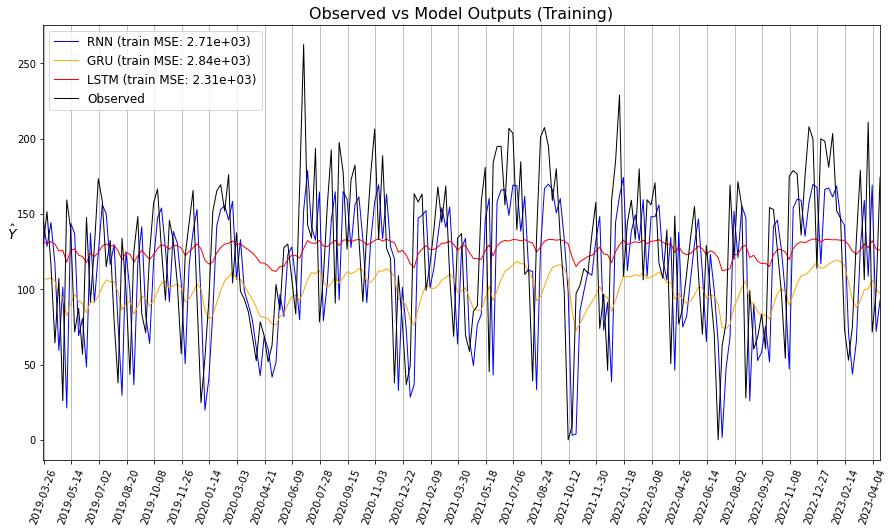

In [183]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

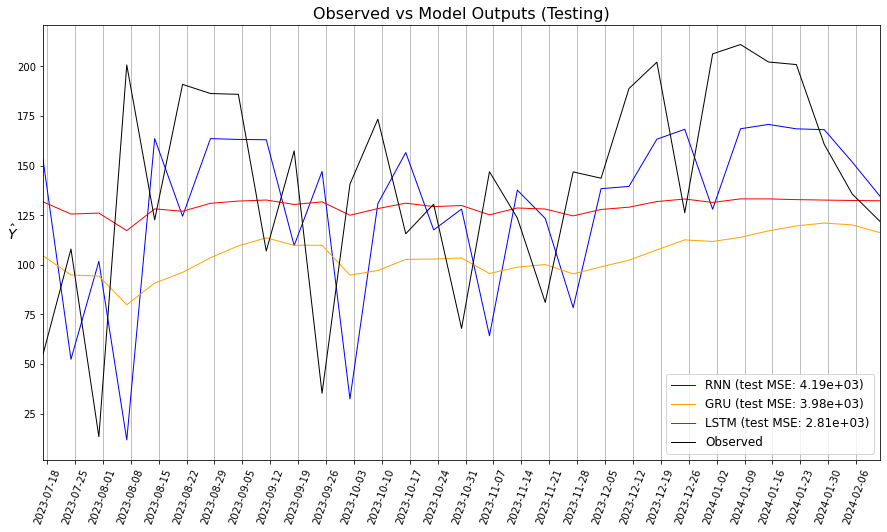

In [184]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

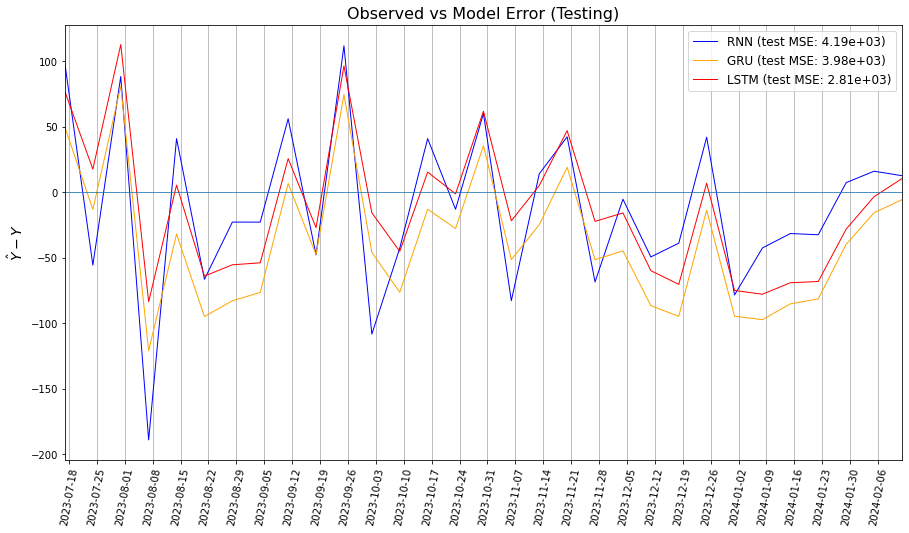

In [185]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

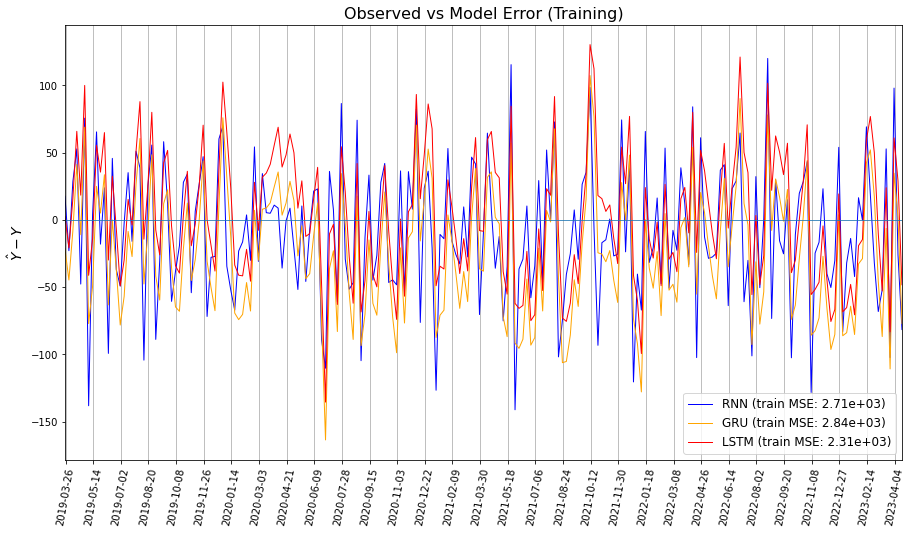

In [186]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);

<h2 style="color: #e67e22; text-align: left;">Diagnóstico del modelo</h2> 

Un modelo ajustado de series temporales debe ser examinado para la subajustado con una prueba de ruido blanco. Analizamos los residuos del modelo (es decir, el error) para determinar si es ruido blanco o si está autocorrelacionado. En el último caso, esto proporciona evidencia estadística de que se necesitan más rezagos en la RNN.

In [187]:
# number of samples to use for computing test statistic
n = 100000

In [188]:
params.keys()

dict_keys(['rnn', 'gru', 'lstm'])

In [192]:
key = 'rnn'
predicted = params[key]['pred_test']
residual = y_test[-n:] - predicted[-n:]

In [193]:
statistic_lb = sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False,return_df=True)

In [194]:
statistic_lb

,lb_stat,lb_pvalue
1,9.460166,0.002100
2,12.810386,0.001653
3,14.306650,0.002516
4,14.387007,0.006157
5,14.430860,0.013092
6,14.475863,0.024749
7,17.676048,0.013520
8,23.080325,0.003263
9,24.912261,0.003070
10,25.519550,0.004443


La prueba puede ser consumidora de tiempo y seleccionamos un subconjunto de los residuos. Aquí simplemente establecemos el número máximo de rezagos en 20. En los resultados a continuación, encontramos que los valores p son todos mayores que 0.01, lo que indica que NO podemos rechazar la hipótesis nula con un nivel de confianza del 99% para cualquier rezago. Esto es evidencia sólida de que el modelo no está subajustado y se necesitan más rezagos en nuestro modelo. A diferencia de un modelo autorregresivo, aumentar el número de rezagos en la RNN no aumenta el número de pesos. Por lo tanto, no hay peligro de sobreajuste al aumentar el rezago, aunque habrá un aumento en el tiempo de entrenamiento.